# DFL + Koopman applied to extended ROA analysis

In [19]:
from darli.models import RobotModel     # Rofl, bez nee casadi ne importiruetsya
import casadi as cs
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.integrate import solve_ivp
from utils import draw_elipse, phase_portrait, sampling_roa
from scipy.linalg import solve_continuous_lyapunov as lyap

## Inverted time Van der Pol oscillator

The equation is:
$$\ddot{x} = -(1-x^2)\dot{v} - x + u$$

For the DFL linearization, let's choose:
$$\eta = \begin{bmatrix} x^2 \dot{x} \end{bmatrix}.$$


If we introduce $q = \begin{bmatrix} x \\ \dot{x} \end{bmatrix}$
Then, the equation would be:
$$\dot{q} = \begin{bmatrix} 0 & 1 \\ -1 & -1 \end{bmatrix} q + \begin{bmatrix} 0 \\ 1 \end{bmatrix} \eta + \begin{bmatrix} 0 \\ 1 \end{bmatrix} u \equiv A_q q + A_\eta \eta + Bu$$


In [20]:
nx, nv = 1, 1

x = cs.SX.sym('x', nx)
v = cs.SX.sym('v', nv)
dv = cs.SX.sym('dv', nv)

state = cs.vertcat(x, v)
state_dot = cs.vertcat(v, dv)

In [21]:
neta_dfl = 1

# === Systems ===
# Inverted-time Van der Pol no. 1
# f = cs.Function("f", [state], [cs.vertcat(v, -(1-x**2)*v - x)])
# eta = x**2 * v
# A_x = np.array([[0, 1], [-1, -1]])
# A_eta = np.array([0, 1]).reshape(-1, 1)

# Inverted-time Van der Pol no. 2
# f = cs.Function("f", [state], [cs.vertcat(v, -2*x -3*v + x**2*v)])
# eta = x**2 * v
# A_x = np.array([[0, 1], [-2, -3]])
# A_eta = np.array([0, 1]).reshape(-1, 1)

# Koopman functions -- Polynomials
aux_funcs = [
    x**2,
    x*v,
    v**2,
    x**3,
    # x**2*v,
    v**2*x,
    v**3,
    x**4,
    x**3*v,
    x**2*v**2,
    x*v**3,
    v**4,
]

neta_rbf = len(aux_funcs)
eta = cs.vertcat(eta, *aux_funcs)
neta = neta_dfl + neta_rbf

In [22]:
# There would be two types of symbolic etas: eta(x) and eta as free variable
# It's important to note which variable is used
eta_sym = cs.SX.sym('eta', neta)

In [23]:
eta_fn = cs.Function("eta", [state], [eta])

# State + auxiliary variables
full_state = cs.vertcat(state, eta)
full_state_sym = cs.vertcat(state, eta_sym)

In [24]:
# Verification that matrices are chosed correctly
f_lin = cs.Function("f_lin", [state], [A_x @ state + A_eta @ eta[:neta_dfl]])

state_np = np.random.uniform(-2, 2, size=(2,))

f_lin(state_np), f(state_np)

(DM([1.78249, -2.11958]), DM([1.78249, -2.11958]))

### Data sampling

In [25]:
# Simulation parameters
dt_sim = 1e-3
dt_sample = 1e-1
n_samples = 50
t_end = 10

# For no. 1
x_range = (-3, 3)
# For no. 2
# x_range = (-2, 2)

Simulating the trajectories using random sampling

In [26]:
ts = np.arange(0, t_end, dt_sim)
save_each = int(dt_sample / dt_sim)
state_samples = []

f_np = lambda t, x: np.array(f(x)).ravel()

# Random generation
np.random.seed(42)
progress_bar = tqdm(total=n_samples)
while len(state_samples) < n_samples:
    state_np = np.random.uniform(*x_range, size=(2,))
    sol = solve_ivp(
        f_np,
        (0, t_end),
        state_np,
        t_eval=ts
    )
    # Check if solution converged or not
    if sol.status == 0:
        progress_bar.update(1)
        state_samples.append(sol.y.T[::save_each])
progress_bar.close()

100%|██████████| 50/50 [00:01<00:00, 27.92it/s]


In [27]:
state_np = np.concatenate(state_samples, axis=0)
v_dot_np = np.array([
    f_np(0, state_i) for state_i in state_np
])

eta_dot = cs.jacobian(eta, state) @ state_dot
eta_dot_fn = cs.Function(
    "eta_dot", 
    [state, dv], 
    [
        eta_dot
    ]
)

eta_np = np.array([
    eta_fn(state_i) for state_i in state_np
])[:, :, 0]

eta_dot_np = np.array([
    eta_dot_fn(state_i, v_dot_i[1]) for state_i, v_dot_i in zip(state_np, v_dot_np)
])[:, :, 0]

full_state_np = np.concatenate([state_np, eta_np], axis=1)
full_state_dot_np = np.concatenate([v_dot_np, eta_dot_np], axis=1)

Solving the optimization problem:

In [28]:
# Option 1 (not used): fitting only auxiliary variable's dynamics
# H_w_cp = cp.Variable((neta, nx+nv+neta))
# objective_samples = 1/len(full_state_np) * cp.sum_squares(eta_dot_np.T - H_w_cp@full_state_np.T) #+ 0.1*cp.norm(H_w_cp)

# Option 2: fitting whole dynamics
H_w_cp = cp.Variable((nx+nv+neta, nx+nv+neta))
objective_samples = cp.sum_squares(full_state_dot_np.T - H_w_cp@full_state_np.T) + cp.sum(cp.abs(H_w_cp)) + cp.sum_squares(H_w_cp)
problem_samples = cp.Problem(cp.Minimize(objective_samples))
result = problem_samples.solve(verbose=True)

H_w = H_w_cp.value

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Jan 24 10:33:02 PM: Your problem has 196 variables, 0 constraints, and 0 parameters.
(CVXPY) Jan 24 10:33:02 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 24 10:33:02 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 24 10:33:02 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 24 10:33:02 PM: Your problem is compiled with the CPP canonicalization backend.


-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 24 10:33:02 PM: Compiling problem (target solver=OSQP).
(CVXPY) Jan 24 10:33:02 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) Jan 24 10:33:02 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jan 24 10:33:02 PM: Applying reduction Qp2SymbolicQp
(CVXPY) Jan 24 10:33:02 PM: Applying reduction QpMatrixStuffing
(CVXPY) Jan 24 10:33:02 PM: Applying reduction OSQP
(CVXPY) Jan 24 10:33:02 PM: Finished problem compilation (took 2.742e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Jan 24 10:33:02 P

 Now let's validate the performance using some initial condition:

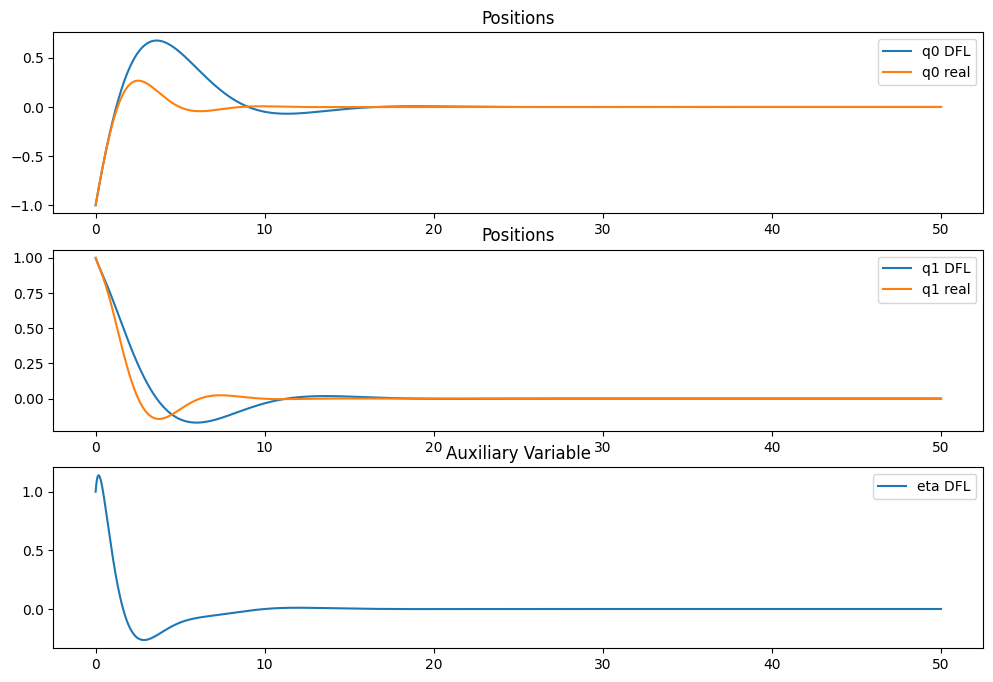

In [29]:
# Redefining time series
t_end = 50
ts = np.arange(0, t_end, dt_sim)

# Linearized function
f_lin = lambda t, x: H_w @ x


state_np = np.array([-1, 1])
eta_np = np.array(eta_fn(state_np)).ravel()
full_state_np = np.concatenate([state_np, eta_np], axis=0)

sol = solve_ivp(
    f_np,
    (0, t_end),
    state_np,
    t_eval=ts
)

lin_sol = solve_ivp(
    f_lin,
    (0, t_end),
    full_state_np,
    t_eval=ts
)

fig, ax = plt.subplots(3, 1, figsize=(12, 8))

for i in range(2):
    ax[i].plot(ts[:len(lin_sol.y[i])], lin_sol.y[i], label=f"q{i} DFL")
    ax[i].set_title('Positions')
    ax[i].plot(ts[:len(sol.y[i])], sol.y[i], label=f"q{i} real")
    ax[i].legend()

eta_sol = np.array(
    [eta_fn(state_i) for state_i in sol.y.T]
).reshape(-1, 1)

ax[2].set_title('Auxiliary Variable')
ax[2].plot(ts[:len(lin_sol.y[-1])], lin_sol.y[-1], label=f"eta DFL")
ax[2].legend()
plt.show()

## Regions of Attraction

### LTI LQR

Now, let's analyse the following Lyapunov candidate:
$$V = \frac{1}{2} \eta^T P \eta,$$
where $P$ is a matrix, resulting from LTI LQR discrete control.

In [30]:
A = H_w
Q = np.eye(nx+nv+neta)
P = lyap(A.T, -Q)

Let's evaluate the levelset using the DFL:

In [31]:
V = 1/2 * full_state.T @ P @ full_state
V_fn = cs.Function('V', [state], [V])
V0 = V_fn(np.zeros(nx+nv))

V_dot_fn = cs.Function('V_dot', [state], [cs.jacobian(V, state) @ f(state)])

In [32]:
state_lims = np.array([
    [-8, -8],
    [8, 8]
])

r_dfl, _ = sampling_roa(f, V_fn, V_dot_fn, state_lims, N = 10000)
levelset_dfl = cs.Function('V_level', [state], [V - r_dfl])
r_dfl

DM(0.00541674)

Now, let's compare it to the Taylor Linearization approximation

In [33]:
jacobian = cs.Function('jacobian', [state], [cs.jacobian(f(state), state)])
A_taylor = jacobian(np.zeros(2))
Q_taylor = np.eye(2)

P_taylor = lyap(A_taylor.T, -Q_taylor)

V_taylor = 1/2 * state.T @ P_taylor @ state
V_taylor_fn = cs.Function('V_taylor', [state], [V_taylor])
V_taylor_dot_fn = cs.Function('V_taylor', [state], [cs.jacobian(V_taylor, state) @ f(state)])

In [34]:
state_lims = np.array([
    [-8, -8],
    [8, 8]
])

r_taylor, _ = sampling_roa(f, V_taylor_fn, V_taylor_dot_fn, state_lims, N = 10000)
levelset_taylor = cs.Function('V_level', [state], [V_taylor - r_taylor])
r_taylor

DM(1.93203)

Now, let's visualize & compare them:

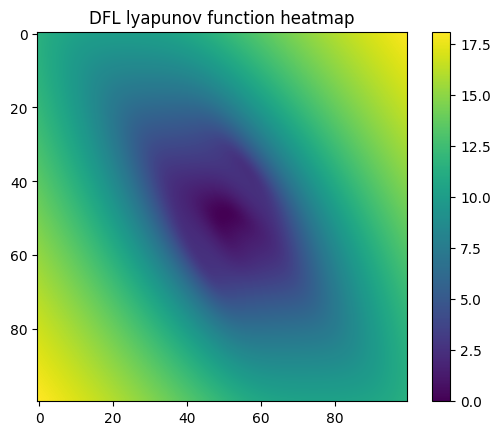

In [35]:
fig, ax = plt.subplots()

# Make data.
dx = 1e-1
X = np.arange(-5, 5, dx)
Y = np.arange(-5, 5, dx)
x_mesh = np.meshgrid(
    X,
    Y,
)

# Calculating mesh of the lyapunov function
lyap_mesh = np.array([
    [
        V_fn([x_mesh[0][i, k], x_mesh[1][i, k]])
        for k in range(x_mesh[0].shape[1])
    ]   for i in range(x_mesh[0].shape[0])
])[:, :, 0, 0]

# Plot the surface.
im = ax.imshow(np.log(lyap_mesh+1)[::-1], interpolation="quadric")
fig.colorbar(im)
ax.set_title('DFL lyapunov function heatmap')
plt.show()

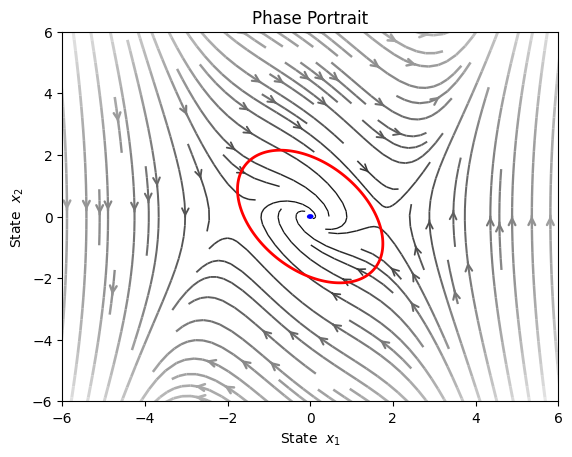

In [36]:
fig, ax = plt.subplots()

x_lim = 6

phase_portrait(f, ax=ax, x_range=[x_lim, x_lim], density=1.2)
draw_elipse(
    [-x_lim, x_lim], 
    ax=ax, 
    f = levelset_taylor, 
    cs_func = True, 
    args=tuple(),
    plt_args = {
        'linewidths': 2,
        'colors': 'red',
    } 
)

draw_elipse(
    [-x_lim, x_lim],
    ax=ax,  
    f = levelset_dfl, 
    cs_func = True, 
    args=tuple(),
    plt_args = {
        'linewidths': 2,
        'colors': 'blue',
    } 
)

plt.show()